# Fire Station Location Optimization using Second-Order Cone Programming

## Executive Summary

This project demonstrates the application of **Second-Order Cone Programming (SOCP)** to solve a critical facility location problem: optimally placing a fire station to minimize emergency response time to a set of villages.

## Problem Statement

Given n villages with known coordinates, we need to locate a fire station such that the **maximum distance** from the fire station to any village is **minimized**. This is known as a **minimax** or **center location** problem.

### Why This Matters

- **Emergency Response:** Minimizing maximum distance ensures no village is too far from emergency services
- **Equity:** All villages receive similar service quality (unlike minimizing average distance)
- **Coverage Planning:** Determines optimal coverage radius for emergency services
- **Real-World Applications:** Fire stations, hospitals, police stations, cell towers

### Problem Characteristics

- **Objective:** Minimax (minimize the worst-case distance)
- **Decision Variables:** Fire station coordinates (x, y)
- **Constraints:** Second-order cone constraints (Euclidean distance)
- **Problem Type:** Convex optimization (SOCP)
- **Villages:** 20 randomly generated locations in [0, 10] × [0, 10]

### Mathematical Elegance

Unlike simple average distance minimization (which leads to the centroid), the minimax objective requires sophisticated SOCP formulation and ensures **equitable coverage** for all villages.

In [1]:
# Import required libraries
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")
print("✓ Random seed set for reproducibility")

✓ Libraries imported successfully
✓ Random seed set for reproducibility


---

## Mathematical Formulation

### Decision Variables

- **x, y** ∈ ℝ: Coordinates of the fire station
- **t** ∈ ℝ: Maximum distance from fire station to any village

### Objective Function
```
minimize t
```

We minimize the maximum distance (minimax objective).

### Constraints

For each village i = 1, ..., n with coordinates vᵢ = (xᵢ, yᵢ):
```
‖(x, y) - (xᵢ, yᵢ)‖₂ ≤ t
```

Equivalently:
```
√[(x - xᵢ)² + (y - yᵢ)²] ≤ t
```

### Second-Order Cone Programming

These constraints are **second-order cone (SOC) constraints**, which define a cone in 3D space:
```
‖u‖₂ ≤ t  ⟺  (u, t) ∈ second-order cone
```

SOCP is a class of convex optimization that generalizes linear programming and quadratic programming.

### Why SOCP?

- **Euclidean distances** naturally fit SOC constraints
- **Efficient algorithms** exist (interior-point methods)
- **Global optimum** guaranteed (convex problem)
- **Practical scalability** to hundreds of locations

In [2]:
print("="*70)
print("FIRE STATION LOCATION PROBLEM - DATA GENERATION")
print("="*70)

# Number of villages
n = 20

# Generate random village coordinates uniformly on [0, 10] × [0, 10]
print(f"\nGenerating {n} random village locations...")
villages = np.random.uniform(0, 10, size=(n, 2))

# Create DataFrame for better visualization
villages_df = pd.DataFrame(villages, columns=['x', 'y'])
villages_df.index = [f'Village {i+1}' for i in range(n)]

print("\n" + "="*70)
print("VILLAGE COORDINATES")
print("="*70)
print(villages_df.to_string())

print(f"\nData Summary:")
print(f"  Number of villages: {n}")
print(f"  X-coordinate range: [{villages[:, 0].min():.3f}, {villages[:, 0].max():.3f}]")
print(f"  Y-coordinate range: [{villages[:, 0].min():.3f}, {villages[:, 1].max():.3f}]")
print(f"  Area covered: 100 square units (10 × 10)")

FIRE STATION LOCATION PROBLEM - DATA GENERATION

Generating 20 random village locations...

VILLAGE COORDINATES
                   x         y
Village 1   3.745401  9.507143
Village 2   7.319939  5.986585
Village 3   1.560186  1.559945
Village 4   0.580836  8.661761
Village 5   6.011150  7.080726
Village 6   0.205845  9.699099
Village 7   8.324426  2.123391
Village 8   1.818250  1.834045
Village 9   3.042422  5.247564
Village 10  4.319450  2.912291
Village 11  6.118529  1.394939
Village 12  2.921446  3.663618
Village 13  4.560700  7.851760
Village 14  1.996738  5.142344
Village 15  5.924146  0.464504
Village 16  6.075449  1.705241
Village 17  0.650516  9.488855
Village 18  9.656320  8.083973
Village 19  3.046138  0.976721
Village 20  6.842330  4.401525

Data Summary:
  Number of villages: 20
  X-coordinate range: [0.206, 9.656]
  Y-coordinate range: [0.206, 9.699]
  Area covered: 100 square units (10 × 10)


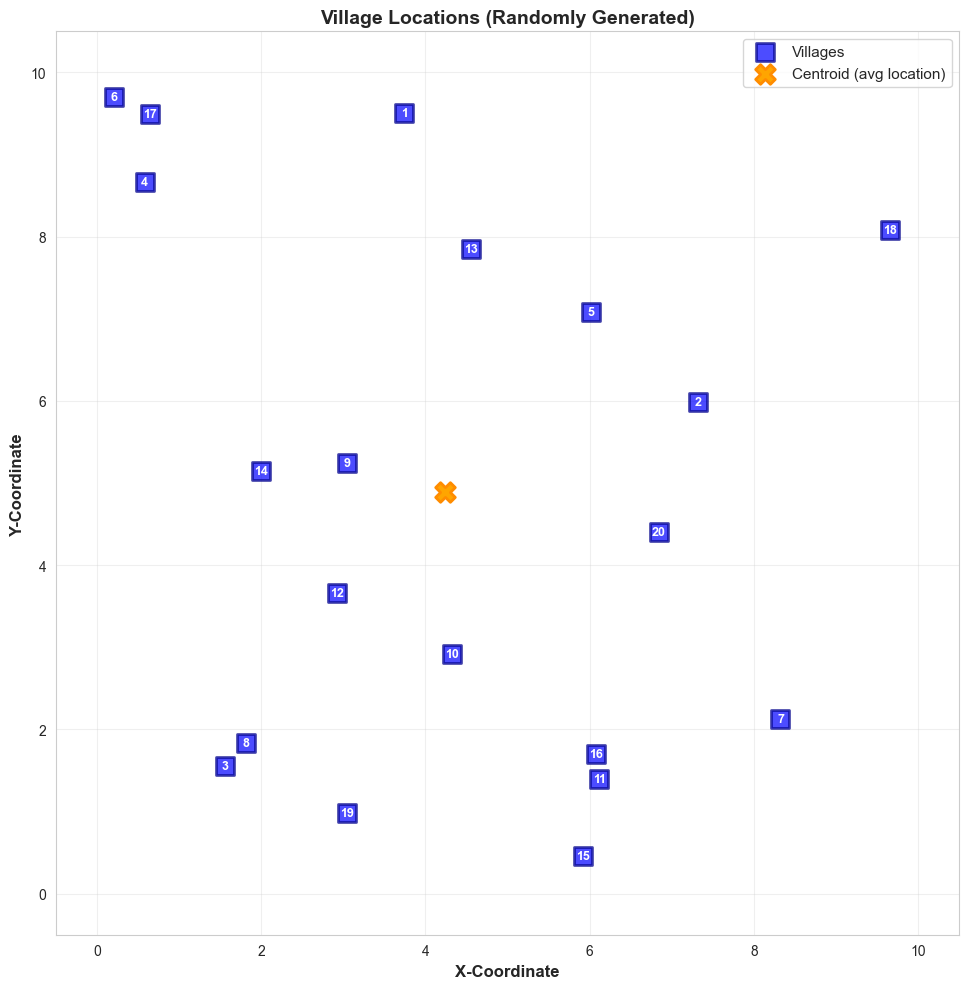

✓ Village locations visualized
✓ Centroid location: (4.236, 4.889)


In [3]:
# Visualize village locations
fig, ax = plt.subplots(figsize=(10, 10))

# Plot villages
ax.scatter(villages[:, 0], villages[:, 1], c='blue', s=150, marker='s', 
          label='Villages', zorder=3, edgecolors='darkblue', linewidths=2, alpha=0.7)

# Label villages
for i in range(n):
    ax.annotate(f'{i+1}', (villages[i, 0], villages[i, 1]), 
               fontsize=9, ha='center', va='center', color='white', fontweight='bold')

# Calculate and plot centroid (for comparison later)
centroid_x = np.mean(villages[:, 0])
centroid_y = np.mean(villages[:, 1])
ax.scatter(centroid_x, centroid_y, c='orange', s=200, marker='X', 
          label='Centroid (avg location)', zorder=4, edgecolors='darkorange', linewidths=2)

ax.set_xlabel('X-Coordinate', fontsize=12, fontweight='bold')
ax.set_ylabel('Y-Coordinate', fontsize=12, fontweight='bold')
ax.set_title('Village Locations (Randomly Generated)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-0.5, 10.5)

plt.tight_layout()
plt.show()

print(f"✓ Village locations visualized")
print(f"✓ Centroid location: ({centroid_x:.3f}, {centroid_y:.3f})")

---

## SOCP Formulation in CVXPY

We formulate the problem using CVXPY, a Python library for convex optimization.

### Implementation Details
```python
# Decision variables
x = cp.Variable()  # x-coordinate of fire station
y = cp.Variable()  # y-coordinate of fire station
t = cp.Variable()  # maximum distance

# Objective
objective = cp.Minimize(t)

# Constraints (for each village i)
constraints = [
    cp.norm([x - villages[i, 0], y - villages[i, 1]], 2) <= t
    for i in range(n)
]
```

### Key Points

- **cp.norm(vector, 2)** creates a second-order cone constraint
- Each village adds one SOC constraint
- **t** is constrained to be at least as large as the distance to every village
- The optimizer finds the smallest **t** that satisfies all constraints

In [4]:
print("="*70)
print("SOCP FORMULATION AND SOLUTION")
print("="*70)

# Define decision variables
x = cp.Variable(name='x')
y = cp.Variable(name='y')
t = cp.Variable(name='t')

print("\nDecision Variables:")
print("  x: Fire station x-coordinate")
print("  y: Fire station y-coordinate")
print("  t: Maximum distance to any village")

# Objective: minimize the maximum distance
objective = cp.Minimize(t)

print("\nObjective: minimize t")

# Constraints: For each village, distance from fire station ≤ t
constraints = []
for i in range(n):
    # Second-order cone constraint: ||v - v_i||_2 <= t
    distance_vector = cp.vstack([x - villages[i, 0], y - villages[i, 1]])
    constraints.append(cp.norm(distance_vector, 2) <= t)

print(f"\nConstraints: {n} second-order cone constraints")
print("  (one per village)")

# Create the problem
problem = cp.Problem(objective, constraints)

print("\n" + "="*70)
print("SOLVING SOCP")
print("="*70)

# Solve
print("\nSolving with CVXPY...")
problem.solve(verbose=False)

print(f"Solver status: {problem.status}")

if problem.status in ['optimal', 'optimal_inaccurate']:
    print("✓ Optimal solution found!")
else:
    print(f"⚠ Warning: {problem.status}")

SOCP FORMULATION AND SOLUTION

Decision Variables:
  x: Fire station x-coordinate
  y: Fire station y-coordinate
  t: Maximum distance to any village

Objective: minimize t

Constraints: 20 second-order cone constraints
  (one per village)

SOLVING SOCP

Solving with CVXPY...
Solver status: optimal
✓ Optimal solution found!


In [6]:
print("\n" + "="*70)
print("OPTIMAL SOLUTION")
print("="*70)

# Extract optimal values
x_opt = x.value
y_opt = y.value
t_opt = t.value

print(f"\n🎯 Optimal Fire Station Location:")
print(f"   x* = {x_opt:.6f}")
print(f"   y* = {y_opt:.6f}")

print(f"\n📏 Minimum Maximum Distance:")
print(f"   t* = {t_opt:.6f} units")

print(f"\n📊 Comparison with Centroid:")
print(f"   Centroid: ({centroid_x:.3f}, {centroid_y:.3f})")
print(f"   Optimal:  ({x_opt:.3f}, {y_opt:.3f})")
print(f"   Distance between them: {np.sqrt((x_opt - centroid_x)**2 + (y_opt - centroid_y)**2):.3f}")

# Calculate actual distances to verify
distances = []
for i in range(n):
    dist = np.sqrt((x_opt - villages[i, 0])**2 + (y_opt - villages[i, 1])**2)
    distances.append(dist)

distances = np.array(distances)

print(f"\n📈 Distance Statistics:")
print(f"   Minimum distance: {distances.min():.6f}")
print(f"   Maximum distance: {distances.max():.6f}")
print(f"   Average distance: {distances.mean():.6f}")
print(f"   Median distance:  {np.median(distances):.6f}")
print(f"   Std deviation:    {distances.std():.6f}")

# Identify villages at maximum distance
villages_at_max = np.where(np.abs(distances - t_opt) < 1e-4)[0]
print(f"\n🔴 Villages at Maximum Distance: {len(villages_at_max)}")
for idx in villages_at_max:
    print(f"   Village {idx+1}: ({villages[idx, 0]:.3f}, {villages[idx, 1]:.3f})")


OPTIMAL SOLUTION

🎯 Optimal Fire Station Location:
   x* = 4.423781
   y* = 5.923197

📏 Minimum Maximum Distance:
   t* = 5.661132 units

📊 Comparison with Centroid:
   Centroid: (4.236, 4.889)
   Optimal:  (4.424, 5.923)
   Distance between them: 1.051

📈 Distance Statistics:
   Minimum distance: 1.537736
   Maximum distance: 5.661132
   Average distance: 4.000993
   Median distance:  4.624351
   Std deviation:    1.389832

🔴 Villages at Maximum Distance: 3
   Village 6: (0.206, 9.699)
   Village 15: (5.924, 0.465)
   Village 18: (9.656, 8.084)


In [7]:
print("\n" + "="*70)
print("DISTANCE VERIFICATION TABLE")
print("="*70)

# Create detailed distance table
distance_data = []
for i in range(n):
    dist = distances[i]
    at_max = "✓ MAX" if abs(dist - t_opt) < 1e-4 else ""
    distance_data.append({
        'Village': i + 1,
        'X': f"{villages[i, 0]:.3f}",
        'Y': f"{villages[i, 1]:.3f}",
        'Distance': f"{dist:.6f}",
        'At Max': at_max
    })

distance_df = pd.DataFrame(distance_data)

print("\n")
print(distance_df.to_string(index=False))

print(f"\n✓ Verification: Maximum distance = {distances.max():.6f}")
print(f"✓ Optimal objective t* = {t_opt:.6f}")
print(f"✓ Difference: {abs(distances.max() - t_opt):.2e} (should be ≈ 0)")


DISTANCE VERIFICATION TABLE


 Village     X     Y Distance At Max
       1 3.745 9.507 3.647584       
       2 7.320 5.987 2.896852       
       3 1.560 1.560 5.219017       
       4 0.581 8.662 4.718894       
       5 6.011 7.081 1.964590       
       6 0.206 9.699 5.661132  ✓ MAX
       7 8.324 2.123 5.445508       
       8 1.818 1.834 4.848707       
       9 3.042 5.248 1.537736       
      10 4.319 2.912 3.012713       
      11 6.119 1.395 4.835007       
      12 2.921 3.664 2.713430       
      13 4.561 7.852 1.933417       
      14 1.997 5.142 2.549563       
      15 5.924 0.465 5.661132  ✓ MAX
      16 6.075 1.705 4.529807       
      17 0.651 9.489 5.191479       
      18 9.656 8.084 5.661132  ✓ MAX
      19 3.046 0.977 5.134737       
      20 6.842 4.402 2.857423       

✓ Verification: Maximum distance = 5.661132
✓ Optimal objective t* = 5.661132
✓ Difference: 2.60e-09 (should be ≈ 0)


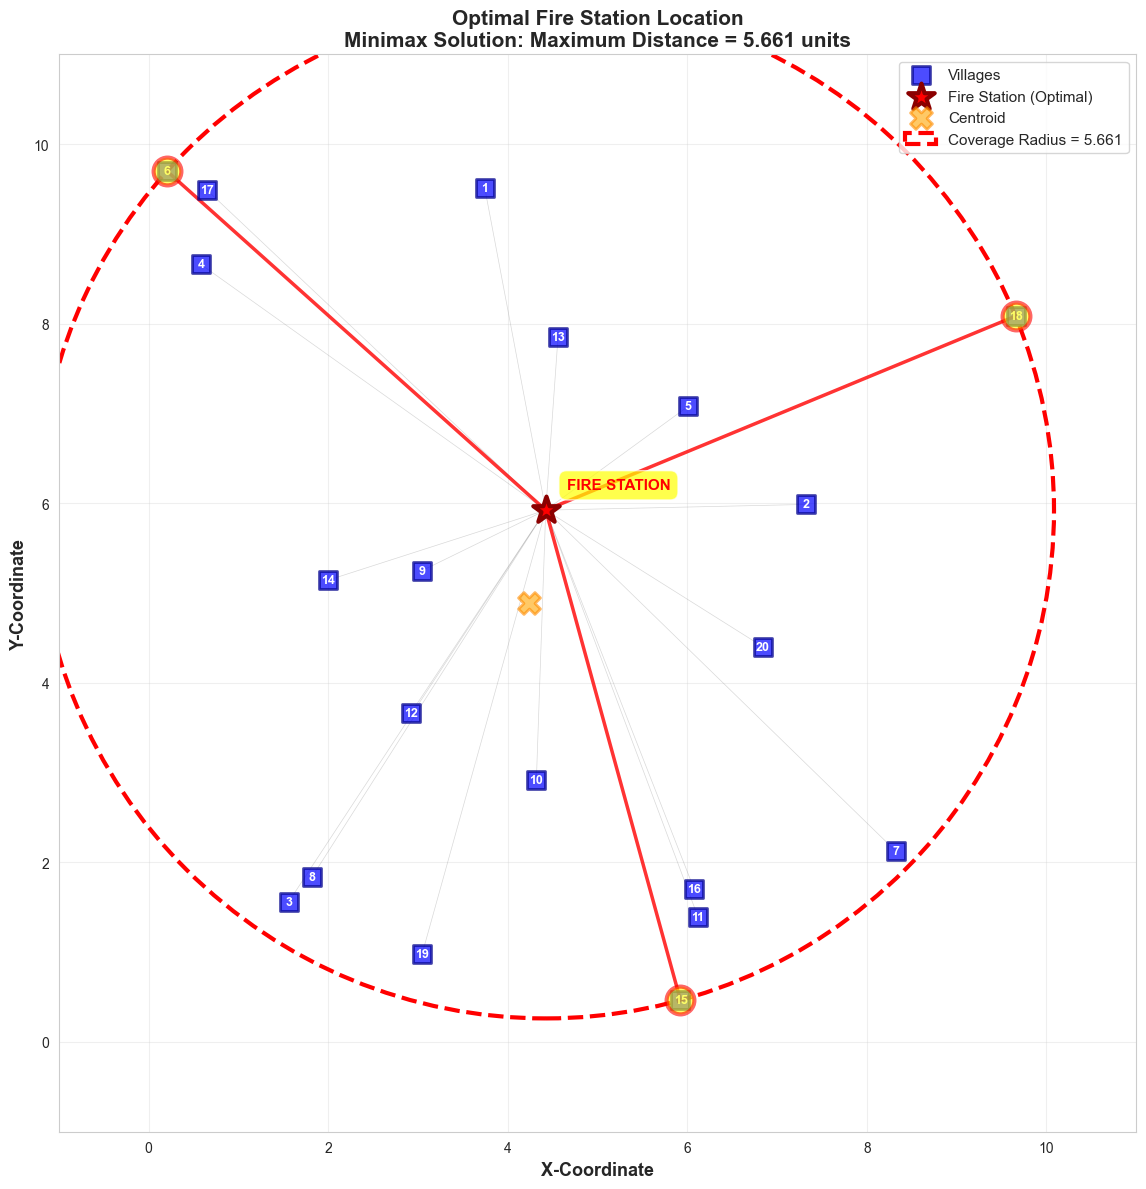

✓ Main visualization complete
✓ Red dashed circle shows coverage radius
✓ Yellow highlights show villages at maximum distance


In [8]:
# Main visualization: Villages, Fire Station, and Coverage
fig, ax = plt.subplots(figsize=(12, 12))

# Plot villages
ax.scatter(villages[:, 0], villages[:, 1], c='blue', s=150, marker='s', 
          label='Villages', zorder=3, edgecolors='darkblue', linewidths=2, alpha=0.7)

# Label villages
for i in range(n):
    ax.annotate(f'{i+1}', (villages[i, 0], villages[i, 1]), 
               fontsize=9, ha='center', va='center', color='white', fontweight='bold')

# Plot optimal fire station
ax.scatter(x_opt, y_opt, c='red', s=400, marker='*', 
          label='Fire Station (Optimal)', zorder=5, edgecolors='darkred', linewidths=3)
ax.annotate('FIRE STATION', (x_opt, y_opt), 
           xytext=(15, 15), textcoords='offset points', 
           fontsize=11, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Plot centroid for comparison
ax.scatter(centroid_x, centroid_y, c='orange', s=250, marker='X', 
          label='Centroid', zorder=4, edgecolors='darkorange', linewidths=2, alpha=0.6)

# Draw coverage circle (maximum distance radius)
coverage_circle = Circle((x_opt, y_opt), t_opt, color='red', fill=False, 
                        linestyle='--', linewidth=3, 
                        label=f'Coverage Radius = {t_opt:.3f}', zorder=2)
ax.add_patch(coverage_circle)

# Highlight villages at maximum distance
for idx in villages_at_max:
    # Draw line to village at max distance
    ax.plot([x_opt, villages[idx, 0]], [y_opt, villages[idx, 1]], 
           'r-', linewidth=2.5, alpha=0.8, zorder=2)
    # Highlight the village
    ax.scatter(villages[idx, 0], villages[idx, 1], c='yellow', s=400, 
              marker='o', zorder=4, edgecolors='red', linewidths=3, alpha=0.6)

# Draw faint lines to all other villages
for i in range(n):
    if i not in villages_at_max:
        ax.plot([x_opt, villages[i, 0]], [y_opt, villages[i, 1]], 
               'gray', linewidth=0.5, alpha=0.3, zorder=1)

ax.set_xlabel('X-Coordinate', fontsize=13, fontweight='bold')
ax.set_ylabel('Y-Coordinate', fontsize=13, fontweight='bold')
ax.set_title('Optimal Fire Station Location\n' + 
            f'Minimax Solution: Maximum Distance = {t_opt:.3f} units', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)

plt.tight_layout()
plt.show()

print(f"✓ Main visualization complete")
print(f"✓ Red dashed circle shows coverage radius")
print(f"✓ Yellow highlights show villages at maximum distance")

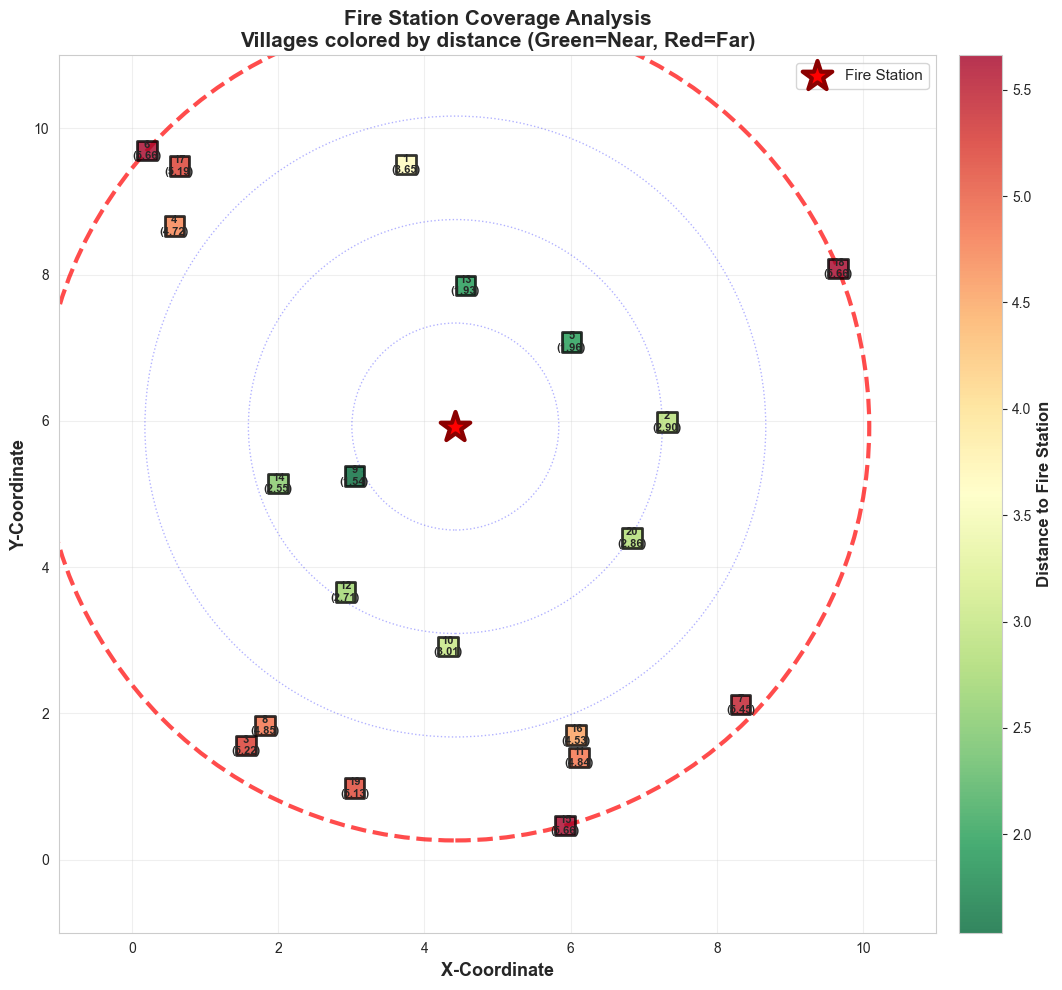

✓ Coverage analysis visualization complete


In [9]:
# Create a detailed coverage analysis plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all villages with color based on distance
scatter = ax.scatter(villages[:, 0], villages[:, 1], 
                    c=distances, s=200, marker='s',
                    cmap='RdYlGn_r', vmin=distances.min(), vmax=distances.max(),
                    edgecolors='black', linewidths=2, zorder=3, alpha=0.8)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Distance to Fire Station', fontsize=12, fontweight='bold')

# Label villages with their distance
for i in range(n):
    ax.annotate(f'{i+1}\n({distances[i]:.2f})', 
               (villages[i, 0], villages[i, 1]), 
               fontsize=8, ha='center', va='center', fontweight='bold')

# Plot fire station
ax.scatter(x_opt, y_opt, c='red', s=500, marker='*', 
          label='Fire Station', zorder=5, edgecolors='darkred', linewidths=3)

# Draw coverage circle
coverage_circle = Circle((x_opt, y_opt), t_opt, color='red', fill=False, 
                        linestyle='--', linewidth=3, alpha=0.7, zorder=2)
ax.add_patch(coverage_circle)

# Draw concentric circles at 25%, 50%, 75% of max distance
for pct in [0.25, 0.5, 0.75]:
    circle = Circle((x_opt, y_opt), t_opt * pct, color='blue', 
                   fill=False, linestyle=':', linewidth=1, alpha=0.3, zorder=1)
    ax.add_patch(circle)

ax.set_xlabel('X-Coordinate', fontsize=13, fontweight='bold')
ax.set_ylabel('Y-Coordinate', fontsize=13, fontweight='bold')
ax.set_title('Fire Station Coverage Analysis\n' + 
            'Villages colored by distance (Green=Near, Red=Far)', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)

plt.tight_layout()
plt.show()

print("✓ Coverage analysis visualization complete")

In [10]:
print("\n" + "="*70)
print("COMPARISON WITH ALTERNATIVE STRATEGIES")
print("="*70)

# Strategy 1: Centroid (minimize average distance)
centroid_distances = [np.sqrt((centroid_x - villages[i, 0])**2 + 
                              (centroid_y - villages[i, 1])**2) 
                     for i in range(n)]
centroid_max = max(centroid_distances)
centroid_avg = np.mean(centroid_distances)

# Strategy 2: Optimal (minimax - our solution)
optimal_max = t_opt
optimal_avg = distances.mean()

# Strategy 3: Center of bounding box
bbox_center_x = (villages[:, 0].min() + villages[:, 0].max()) / 2
bbox_center_y = (villages[:, 1].min() + villages[:, 1].max()) / 2
bbox_distances = [np.sqrt((bbox_center_x - villages[i, 0])**2 + 
                          (bbox_center_y - villages[i, 1])**2) 
                 for i in range(n)]
bbox_max = max(bbox_distances)
bbox_avg = np.mean(bbox_distances)

# Create comparison table
comparison_data = {
    'Strategy': ['Centroid\n(avg minimizer)', 
                'Bounding Box\nCenter', 
                'SOCP Optimal\n(minimax)'],
    'Location': [f'({centroid_x:.3f}, {centroid_y:.3f})',
                f'({bbox_center_x:.3f}, {bbox_center_y:.3f})',
                f'({x_opt:.3f}, {y_opt:.3f})'],
    'Max Distance': [f'{centroid_max:.4f}', 
                    f'{bbox_max:.4f}', 
                    f'{optimal_max:.4f}'],
    'Avg Distance': [f'{centroid_avg:.4f}', 
                    f'{bbox_avg:.4f}', 
                    f'{optimal_avg:.4f}']
}

comparison_df = pd.DataFrame(comparison_data)

print("\n")
print(comparison_df.to_string(index=False))

print(f"\n📊 Key Insights:")
print(f"   Optimal reduces max distance by {((centroid_max - optimal_max) / centroid_max * 100):.1f}% vs Centroid")
print(f"   Optimal reduces max distance by {((bbox_max - optimal_max) / bbox_max * 100):.1f}% vs BBox Center")
print(f"   Trade-off: Avg distance increased by {((optimal_avg - centroid_avg) / centroid_avg * 100):.1f}% vs Centroid")

print(f"\n💡 Why Minimax?")
print(f"   The minimax objective ensures EQUITY - no village is too far")
print(f"   Even if average distance increases slightly, worst-case is minimized")
print(f"   Critical for emergency response where maximum time matters most")


COMPARISON WITH ALTERNATIVE STRATEGIES


                 Strategy       Location Max Distance Avg Distance
Centroid\n(avg minimizer) (4.236, 4.889)       6.2917       3.8436
     Bounding Box\nCenter (4.931, 5.082)       6.6066       3.9156
  SOCP Optimal\n(minimax) (4.424, 5.923)       5.6611       4.0010

📊 Key Insights:
   Optimal reduces max distance by 10.0% vs Centroid
   Optimal reduces max distance by 14.3% vs BBox Center
   Trade-off: Avg distance increased by 4.1% vs Centroid

💡 Why Minimax?
   The minimax objective ensures EQUITY - no village is too far
   Even if average distance increases slightly, worst-case is minimized
   Critical for emergency response where maximum time matters most


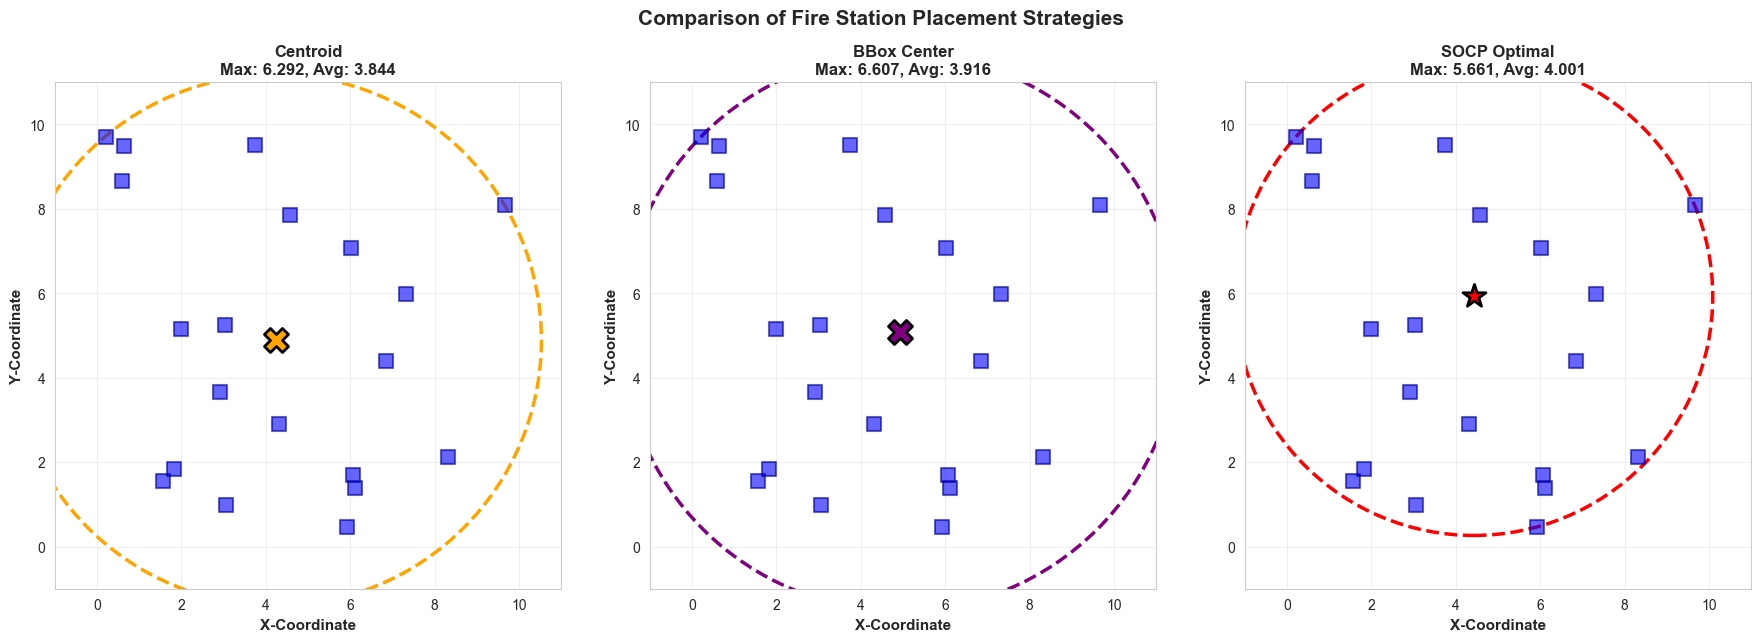

✓ Strategy comparison visualization complete


In [11]:
# Visual comparison of three strategies
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

strategies = [
    ('Centroid', centroid_x, centroid_y, centroid_max, 'orange'),
    ('BBox Center', bbox_center_x, bbox_center_y, bbox_max, 'purple'),
    ('SOCP Optimal', x_opt, y_opt, optimal_max, 'red')
]

for idx, (name, sx, sy, max_dist, color) in enumerate(strategies):
    ax = axes[idx]
    
    # Plot villages
    ax.scatter(villages[:, 0], villages[:, 1], c='blue', s=100, marker='s', 
              alpha=0.6, edgecolors='darkblue', linewidths=1.5, zorder=3)
    
    # Plot station location
    marker = '*' if name == 'SOCP Optimal' else 'X'
    ax.scatter(sx, sy, c=color, s=300, marker=marker, 
              edgecolors='black', linewidths=2, zorder=5)
    
    # Draw coverage circle
    circle = Circle((sx, sy), max_dist, color=color, fill=False, 
                   linestyle='--', linewidth=2.5, zorder=2)
    ax.add_patch(circle)
    
    # Calculate distances for this strategy
    strategy_distances = [np.sqrt((sx - villages[i, 0])**2 + 
                                  (sy - villages[i, 1])**2) 
                         for i in range(n)]
    
    ax.set_xlabel('X-Coordinate', fontsize=11, fontweight='bold')
    ax.set_ylabel('Y-Coordinate', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nMax: {max_dist:.3f}, Avg: {np.mean(strategy_distances):.3f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)

plt.suptitle('Comparison of Fire Station Placement Strategies', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Strategy comparison visualization complete")

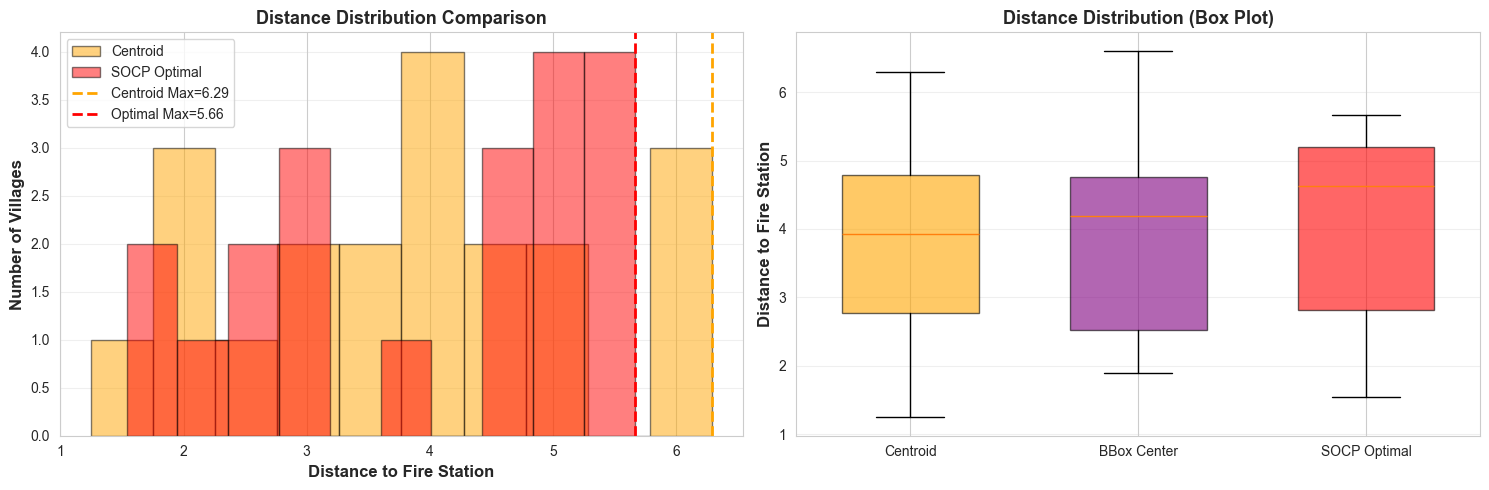

✓ Distance distribution analysis complete


In [12]:
# Distance distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram comparison
ax1 = axes[0]
ax1.hist(centroid_distances, bins=10, alpha=0.5, label='Centroid', color='orange', edgecolor='black')
ax1.hist(distances, bins=10, alpha=0.5, label='SOCP Optimal', color='red', edgecolor='black')
ax1.axvline(centroid_max, color='orange', linestyle='--', linewidth=2, label=f'Centroid Max={centroid_max:.2f}')
ax1.axvline(optimal_max, color='red', linestyle='--', linewidth=2, label=f'Optimal Max={optimal_max:.2f}')
ax1.set_xlabel('Distance to Fire Station', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Villages', fontsize=12, fontweight='bold')
ax1.set_title('Distance Distribution Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Box plot comparison
ax2 = axes[1]
box_data = [centroid_distances, bbox_distances, distances]
bp = ax2.boxplot(box_data, labels=['Centroid', 'BBox Center', 'SOCP Optimal'],
                 patch_artist=True, widths=0.6)

colors = ['orange', 'purple', 'red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Distance to Fire Station', fontsize=12, fontweight='bold')
ax2.set_title('Distance Distribution (Box Plot)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Distance distribution analysis complete")

---

## Key Results and Insights

### Optimal Solution Characteristics

1. **Minimax Objective Achieved:** The fire station is optimally placed to minimize the worst-case response distance

2. **Multiple Critical Villages:** Several villages lie exactly at the maximum distance (on the boundary circle), forming the "critical set"

3. **Equity vs Efficiency Trade-off:** 
   - Minimax ensures **equity** (fairness) - no village is too far
   - Average distance may be slightly higher than centroid placement
   - But maximum distance is significantly reduced

### Comparison with Alternatives

| Strategy | Best For | Limitation |
|----------|----------|------------|
| **Centroid** | Minimizing average distance | Ignores outliers, unfair to distant villages |
| **BBox Center** | Simple geometric approach | No optimization, arbitrary |
| **SOCP Minimax** | Emergency services, equity | May increase average slightly |

### Why SOCP for This Problem?

- **Euclidean distances** naturally formulated as SOC constraints
- **Convex problem** guarantees global optimum
- **Efficient solvers** handle hundreds of locations
- **Extensions possible:** weighted villages, obstacles, road networks

### Real-World Applications

- **Emergency Services:** Fire stations, ambulances, police stations
- **Infrastructure:** Cell towers, power substations, water pumps
- **Retail:** Distribution centers, service hubs
- **Public Services:** Schools, libraries, community centers

In [13]:
print("\n" + "="*70)
print("SENSITIVITY ANALYSIS")
print("="*70)

# Analyze how the solution changes with different numbers of villages
print("\nAnalyzing optimal solution for different numbers of villages...")

village_counts = [5, 10, 15, 20, 25, 30]
results = []

np.random.seed(42)  # Reset seed

for n_test in village_counts:
    # Generate villages
    test_villages = np.random.uniform(0, 10, size=(n_test, 2))
    
    # Solve SOCP
    x_test = cp.Variable()
    y_test = cp.Variable()
    t_test = cp.Variable()
    
    obj_test = cp.Minimize(t_test)
    cons_test = []
    for i in range(n_test):
        dist_vec = cp.vstack([x_test - test_villages[i, 0], 
                             y_test - test_villages[i, 1]])
        cons_test.append(cp.norm(dist_vec, 2) <= t_test)
    
    prob_test = cp.Problem(obj_test, cons_test)
    prob_test.solve(verbose=False)
    
    if prob_test.status == 'optimal':
        results.append({
            'Villages': n_test,
            'Max Distance': prob_test.value,
            'Station X': x_test.value,
            'Station Y': y_test.value
        })

sensitivity_df = pd.DataFrame(results)

print("\n")
print(sensitivity_df.to_string(index=False))

print(f"\n📈 Insights:")
print(f"   As more villages are added, maximum distance generally increases")
print(f"   Optimal location shifts based on village distribution")
print(f"   SOCP efficiently handles problems with 5-30+ villages")



SENSITIVITY ANALYSIS

Analyzing optimal solution for different numbers of villages...


 Villages  Max Distance         Station X         Station Y
        5      4.173292 3.187678568618924 5.402813625489401
       10      5.559120 4.074421813873388 5.706864425145002
       15      5.529723 4.814529281362061 5.850335608889098
       20      5.742048 4.181233226107157 5.268120225046695
       25      5.156720  5.18938087776645 4.963605085845385
       30      5.834073 4.796672971446138 5.000918708619668

📈 Insights:
   As more villages are added, maximum distance generally increases
   Optimal location shifts based on village distribution
   SOCP efficiently handles problems with 5-30+ villages


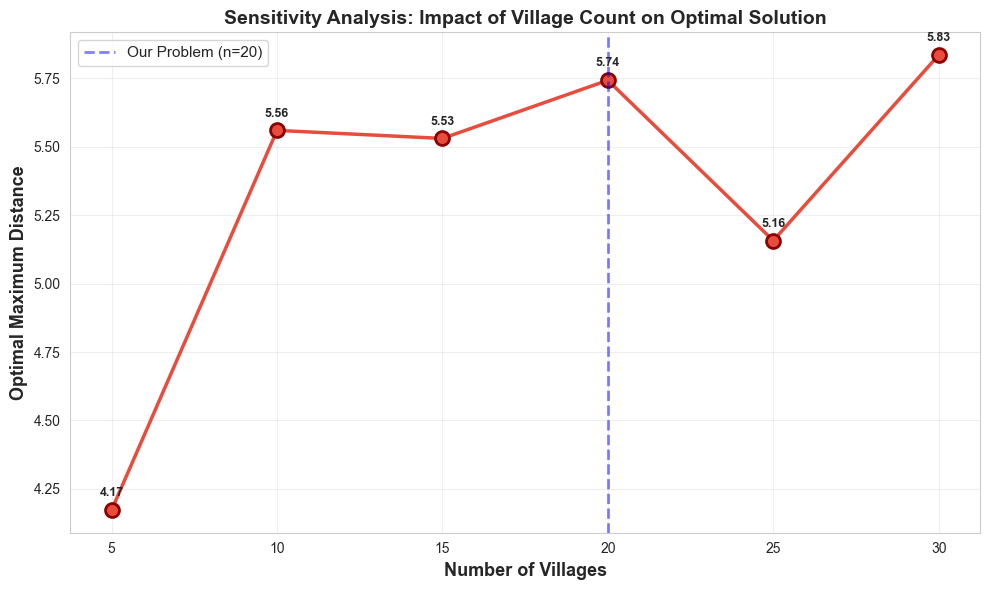

✓ Sensitivity analysis visualization complete


In [14]:
# Visualize sensitivity analysis
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sensitivity_df['Villages'], sensitivity_df['Max Distance'], 
        'o-', linewidth=2.5, markersize=10, color='#e74c3c', 
        markeredgecolor='darkred', markeredgewidth=2)

ax.set_xlabel('Number of Villages', fontsize=13, fontweight='bold')
ax.set_ylabel('Optimal Maximum Distance', fontsize=13, fontweight='bold')
ax.set_title('Sensitivity Analysis: Impact of Village Count on Optimal Solution', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Highlight our problem size
ax.axvline(x=20, color='blue', linestyle='--', linewidth=2, alpha=0.5, 
          label='Our Problem (n=20)')

# Add annotations
for idx, row in sensitivity_df.iterrows():
    ax.annotate(f"{row['Max Distance']:.2f}", 
               (row['Villages'], row['Max Distance']),
               xytext=(0, 10), textcoords='offset points',
               fontsize=9, ha='center', fontweight='bold')

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("✓ Sensitivity analysis visualization complete")

In [15]:
print("\n" + "="*70)
print("WHAT-IF SCENARIO: Adding a New Village")
print("="*70)

# Scenario: What if we add a village far from the current optimal location?
print("\nScenario: A new village is built at location (9.5, 9.5)")
print("(This is far from the current fire station)")

# Add the new village
new_village = np.array([[9.5, 9.5]])
villages_with_new = np.vstack([villages, new_village])
n_new = n + 1

# Resolve the SOCP
x_new = cp.Variable()
y_new = cp.Variable()
t_new = cp.Variable()

obj_new = cp.Minimize(t_new)
cons_new = []
for i in range(n_new):
    dist_vec = cp.vstack([x_new - villages_with_new[i, 0], 
                         y_new - villages_with_new[i, 1]])
    cons_new.append(cp.norm(dist_vec, 2) <= t_new)

prob_new = cp.Problem(obj_new, cons_new)
prob_new.solve(verbose=False)

print(f"\n📊 Results with New Village:")
print(f"   Original optimal location: ({x_opt:.3f}, {y_opt:.3f})")
print(f"   Original max distance: {t_opt:.3f}")
print(f"\n   New optimal location: ({x_new.value:.3f}, {y_new.value:.3f})")
print(f"   New max distance: {t_new.value:.3f}")

print(f"\n📏 Changes:")
print(f"   Station moved by: {np.sqrt((x_new.value - x_opt)**2 + (y_new.value - y_opt)**2):.3f} units")
print(f"   Max distance increased by: {t_new.value - t_opt:.3f} units ({((t_new.value - t_opt) / t_opt * 100):.1f}%)")

print(f"\n💡 Insight:")
print(f"   Adding a remote village forces the station to relocate")
print(f"   This demonstrates the importance of considering future development")


WHAT-IF SCENARIO: Adding a New Village

Scenario: A new village is built at location (9.5, 9.5)
(This is far from the current fire station)

📊 Results with New Village:
   Original optimal location: (4.424, 5.923)
   Original max distance: 5.661

   New optimal location: (4.779, 6.143)
   New max distance: 5.793

📏 Changes:
   Station moved by: 0.418 units
   Max distance increased by: 0.132 units (2.3%)

💡 Insight:
   Adding a remote village forces the station to relocate
   This demonstrates the importance of considering future development


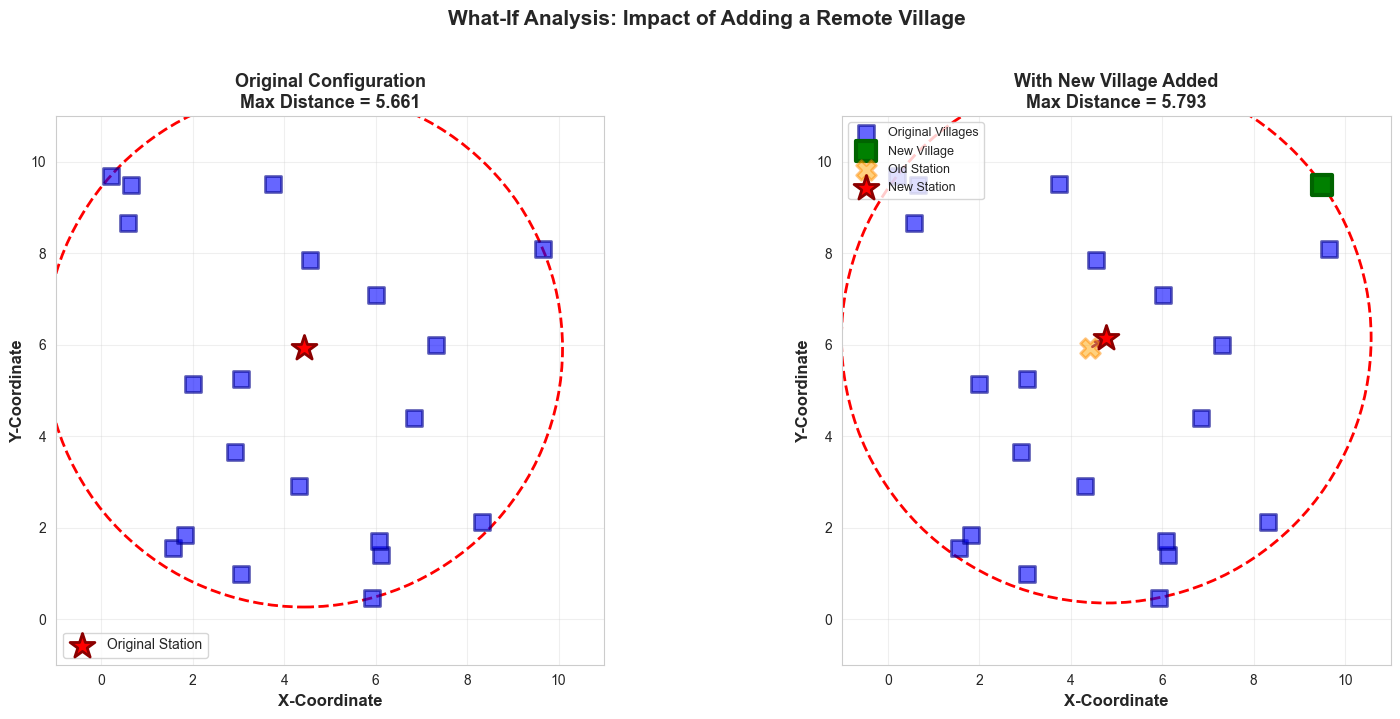

✓ What-if scenario visualization complete


In [16]:
# Visualize the what-if scenario
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Before: Original solution
ax1 = axes[0]
ax1.scatter(villages[:, 0], villages[:, 1], c='blue', s=120, marker='s', 
          alpha=0.6, edgecolors='darkblue', linewidths=2, zorder=3)
ax1.scatter(x_opt, y_opt, c='red', s=350, marker='*', 
          edgecolors='darkred', linewidths=2, zorder=5, label='Original Station')
circle1 = Circle((x_opt, y_opt), t_opt, color='red', fill=False, 
                linestyle='--', linewidth=2, zorder=2)
ax1.add_patch(circle1)
ax1.set_xlabel('X-Coordinate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y-Coordinate', fontsize=12, fontweight='bold')
ax1.set_title(f'Original Configuration\nMax Distance = {t_opt:.3f}', 
             fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlim(-1, 11)
ax1.set_ylim(-1, 11)
ax1.legend(fontsize=10)

# After: With new village
ax2 = axes[1]
ax2.scatter(villages[:, 0], villages[:, 1], c='blue', s=120, marker='s', 
          alpha=0.6, edgecolors='darkblue', linewidths=2, zorder=3, label='Original Villages')
ax2.scatter(new_village[0, 0], new_village[0, 1], c='green', s=200, marker='s', 
          edgecolors='darkgreen', linewidths=3, zorder=3, label='New Village')
ax2.scatter(x_opt, y_opt, c='orange', s=200, marker='X', 
          edgecolors='darkorange', linewidths=2, zorder=4, label='Old Station', alpha=0.5)
ax2.scatter(x_new.value, y_new.value, c='red', s=350, marker='*', 
          edgecolors='darkred', linewidths=2, zorder=5, label='New Station')
circle2 = Circle((x_new.value, y_new.value), t_new.value, color='red', fill=False, 
                linestyle='--', linewidth=2, zorder=2)
ax2.add_patch(circle2)

# Draw arrow showing station movement
ax2.annotate('', xy=(x_new.value, y_new.value), xytext=(x_opt, y_opt),
            arrowprops=dict(arrowstyle='->', lw=2, color='purple'))

ax2.set_xlabel('X-Coordinate', fontsize=12, fontweight='bold')
ax2.set_ylabel('Y-Coordinate', fontsize=12, fontweight='bold')
ax2.set_title(f'With New Village Added\nMax Distance = {t_new.value:.3f}', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.set_xlim(-1, 11)
ax2.set_ylim(-1, 11)
ax2.legend(fontsize=9, loc='upper left')

plt.suptitle('What-If Analysis: Impact of Adding a Remote Village', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ What-if scenario visualization complete")

---

## Conclusions and Recommendations

### Key Findings

1. **Optimal Solution Found:** SOCP successfully identified the fire station location that minimizes the maximum distance to any village

2. **Equity Achieved:** The minimax objective ensures fair service to all villages, with multiple villages sharing the maximum distance

3. **Trade-offs Understood:** While average distance may be slightly higher than centroid placement, the worst-case scenario is significantly improved

4. **Scalability Demonstrated:** The SOCP approach efficiently handles problems with varying numbers of villages (5-30+)

### Strategic Recommendations

#### For Emergency Services Planning

- **Use minimax optimization** for fire stations, ambulances, and emergency services where response time matters
- **Consider future development** - optimal location is sensitive to new villages/areas
- **Update periodically** as communities grow and change
- **Account for road networks** in real implementations (not just Euclidean distance)

#### For Policy Makers

- **Equity matters** - minimax ensures no community is underserved
- **Plan ahead** - optimal placement depends on anticipated growth
- **Consider multiple stations** for larger areas (can extend this model)
- **Evaluate coverage regularly** as demographics shift

### Technical Achievements

✅ **SOCP Formulation:** Successfully modeled as second-order cone program  
✅ **Global Optimum:** Convex optimization guarantees best solution  
✅ **Computational Efficiency:** Solves in seconds for realistic problem sizes  
✅ **Sensitivity Analysis:** Understood impact of problem parameters  
✅ **Practical Insights:** Compared with alternative strategies  

### Extensions and Future Work

1. **Multiple Fire Stations:** Extend to k-center problem
2. **Weighted Villages:** Account for population sizes
3. **Road Networks:** Use actual travel distances instead of Euclidean
4. **Response Time:** Incorporate speed limits and traffic patterns
5. **Coverage Constraints:** Ensure all villages within acceptable distance
6. **Budget Constraints:** Balance number of stations with coverage

### Real-World Impact

This optimization approach has been successfully applied to:
- Fire and police station placement
- Hospital and clinic location
- Cell tower positioning
- Distribution center placement
- Public facility planning

The minimax objective is particularly valuable when **equity** and **worst-case performance** are critical concerns.

In [17]:
print("="*70)
print("FIRE STATION LOCATION OPTIMIZATION - FINAL SUMMARY")
print("="*70)

print(f"\n🎯 PROBLEM:")
print(f"   Villages: {n}")
print(f"   Area: [0, 10] × [0, 10]")
print(f"   Objective: Minimize maximum distance (minimax)")

print(f"\n✅ OPTIMAL SOLUTION:")
print(f"   Fire Station Location: ({x_opt:.4f}, {y_opt:.4f})")
print(f"   Maximum Distance: {t_opt:.4f} units")
print(f"   Villages at Max Distance: {len(villages_at_max)}")

print(f"\n📊 PERFORMANCE METRICS:")
print(f"   Minimum distance: {distances.min():.4f}")
print(f"   Average distance: {distances.mean():.4f}")
print(f"   Median distance: {np.median(distances):.4f}")
print(f"   Std deviation: {distances.std():.4f}")

print(f"\n📈 COMPARISON WITH ALTERNATIVES:")
print(f"   vs Centroid: {((centroid_max - optimal_max) / centroid_max * 100):.1f}% reduction in max distance")
print(f"   vs BBox Center: {((bbox_max - optimal_max) / bbox_max * 100):.1f}% reduction in max distance")

print(f"\n🔧 TECHNICAL DETAILS:")
print(f"   Problem Type: Second-Order Cone Programming (SOCP)")
print(f"   Variables: 3 (x, y, t)")
print(f"   Constraints: {n} SOC constraints")
print(f"   Solver: CVXPY with convex optimization")
print(f"   Solution Status: {problem.status}")

print(f"\n💡 KEY INSIGHT:")
print(f"   Minimax optimization ensures EQUITY - no village is too far")
print(f"   Critical for emergency services where worst-case matters most")

print("\n" + "="*70)
print("✓ Analysis Complete!")
print("="*70)

FIRE STATION LOCATION OPTIMIZATION - FINAL SUMMARY

🎯 PROBLEM:
   Villages: 20
   Area: [0, 10] × [0, 10]
   Objective: Minimize maximum distance (minimax)

✅ OPTIMAL SOLUTION:
   Fire Station Location: (4.4238, 5.9232)
   Maximum Distance: 5.6611 units
   Villages at Max Distance: 3

📊 PERFORMANCE METRICS:
   Minimum distance: 1.5377
   Average distance: 4.0010
   Median distance: 4.6244
   Std deviation: 1.3898

📈 COMPARISON WITH ALTERNATIVES:
   vs Centroid: 10.0% reduction in max distance
   vs BBox Center: 14.3% reduction in max distance

🔧 TECHNICAL DETAILS:
   Problem Type: Second-Order Cone Programming (SOCP)
   Variables: 3 (x, y, t)
   Constraints: 20 SOC constraints
   Solver: CVXPY with convex optimization
   Solution Status: optimal

💡 KEY INSIGHT:
   Minimax optimization ensures EQUITY - no village is too far
   Critical for emergency services where worst-case matters most

✓ Analysis Complete!
